In [2]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define Classes

In [3]:
class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "Add",
    "Decimal",
    "Division",
    "Equals",
    "Multiply",
    "Minus",
    "X",
    "Y",
    "Z",
]

# Load Model

In [4]:
model = tf.keras.models.load_model("../models/19_class.h5")

lite = tf.lite.Interpreter(model_path = '../models/tflite_quant_model.tflite')
input_details = lite.get_input_details()
output_details = lite.get_output_details()
lite.resize_tensor_input(input_details[0]['index'], (1, 100, 100,3))
lite.resize_tensor_input(output_details[0]['index'],(1,19))
lite.allocate_tensors()

2022-04-12 05:01:43.346641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Helper Function

In [5]:
def show_img(img):
    plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)
    
def extra_padding(img, padding=50):
    return cv.copyMakeBorder(img, top=padding, bottom=padding, left=padding, right=padding, borderType=cv.BORDER_CONSTANT, value=(255,255,255))
    
    
def show_images(images, title=''):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        plt.subplot(4,4,i+1)
        plt.imshow(image)
        plt.title(title)
    
    
def show_prediction(image):
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255
    predictions = model.predict(image)
    label = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)*100
    confidence = str(confidence)[:2]
    return label,confidence

def show_prediction_lite(image):
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255
    lite.set_tensor(input_details[0]['index'], image)
    lite.invoke()
    predictions = lite.get_tensor(output_details[0]['index'])
    label = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)*100
    confidence = str(confidence)[:2]
    return label,confidence
    

# Image segmentation

#

(602, 602, 3)


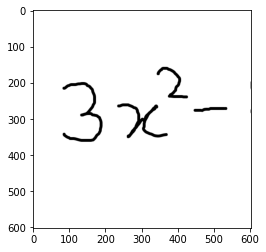

In [6]:
img_path = './image.png'
image = cv.imread(img_path,cv.IMREAD_UNCHANGED)
try:
    alpha = image[:,:,3]
    alpha = cv.bitwise_not(alpha)
    new_image = cv.merge([alpha,alpha,alpha])
    image = new_image
except:
    pass
finally:
    print(image.shape)
    show_img(image)

# Do some preprocessing

In [7]:
def get_contour(image):
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    edged = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 11, 4)
    (contours, _) = cv.findContours(edged, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    return contours
    
contours = get_contour(image)

# Find Bounding box using Contours 

In [8]:
def get_bounding_box(contours):
    chars_bb = []
    for contour in contours:
                contour = contour.reshape((contour.shape[0],contour.shape[2]))
                left_tc = np.amin(contour, axis=0)
                right_bc = np.amax(contour, axis=0)
                min_x = left_tc[0]
                max_x = right_bc[0]
                min_y = left_tc[1]
                max_y = right_bc[1]
                chars_bb.append([min_x,min_y,max_x,max_y])
    return chars_bb


chars_bb = get_bounding_box(contours)

# Show bounding box

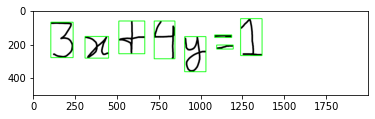

In [9]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),3)
    
show_img(copy)

As we can see = (equals) is detected as double -(minus)

# Replacing Double Minus as EqualsTo

In [12]:
def remove_equals(chars_bb):    
    chars_bb.sort()
    for i, box in enumerate(chars_bb):
        try:
            next_box = chars_bb[i+1]
        except IndexError:
            break
    
        if abs(box[0] - next_box[0]) <= 30:
            min_x = min(box[0],next_box[0])
            min_y = min(box[1],next_box[1])
            max_x = max(box[2],next_box[2])
            max_y = max(box[3],next_box[3])
            new_box = [min_x,min_y,max_x,max_y]
            chars_bb[i] = new_box
            chars_bb.remove(next_box)
    return chars_bb 
        
chars_bb = remove_equals(chars_bb)        

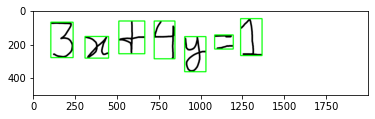

In [13]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),5)
    
show_img(copy)

# Crop the images and get predictions

In [14]:
croped_images = []
copy = image.copy()
for box in chars_bb:
    x_min = box[0]
    y_min = box[1]
    height = abs(box[0]-box[2])
    width = abs(box[1]-box[3])
    character = copy[y_min:y_min+width , x_min:x_min+height]
    croped_images.append(character)
    

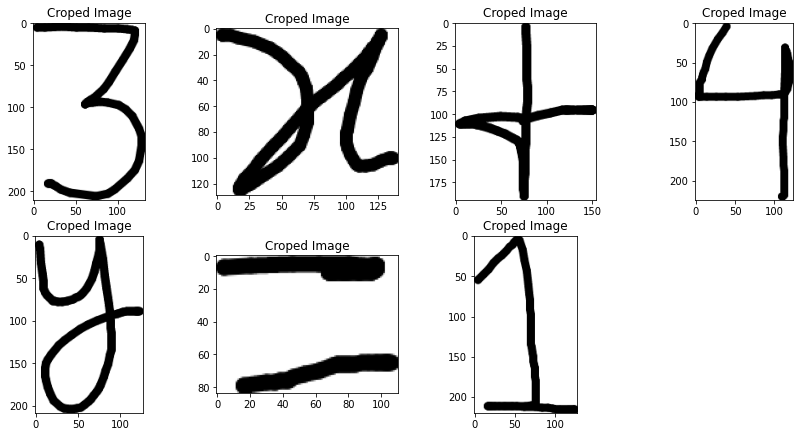

In [15]:
show_images(croped_images, title='Croped Image')

Notice how zoomed in the cropped image is!! 
Our model is not used to seeing images this up close so it may not able to classify images correctly if we feed this image direclty.
We need to apply some padding to this image so the image resemble someting in the traning dataset 

# Pad and resize images
extra_padding() method adds 50px padding to all sides of an image 

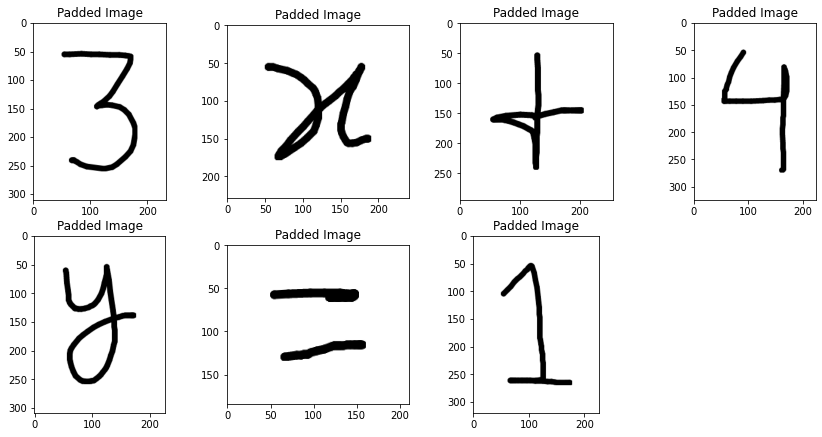

In [20]:
padded_images = []
for img in croped_images:
    padded_img = extra_padding(img)
    padded_images.append(padded_img)

show_images(padded_images, title='Padded Image')

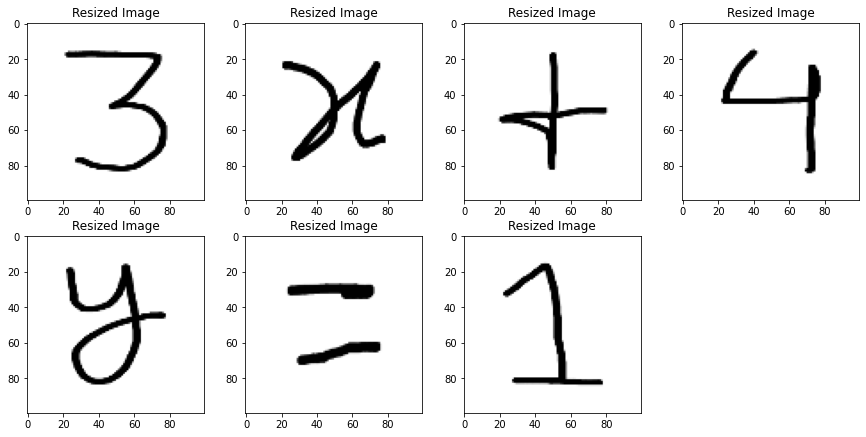

In [21]:
def resize_image(images):
    resized_images = []
    for img in images:
        resized_img = cv.resize(img, (100, 100), interpolation=cv.INTER_LINEAR)
        resized_images.append(resized_img)
    return resized_images

resized_images = resize_image(padded_images)
show_images(resized_images, title='Resized Image')

Now lets run inference on each image and see the output

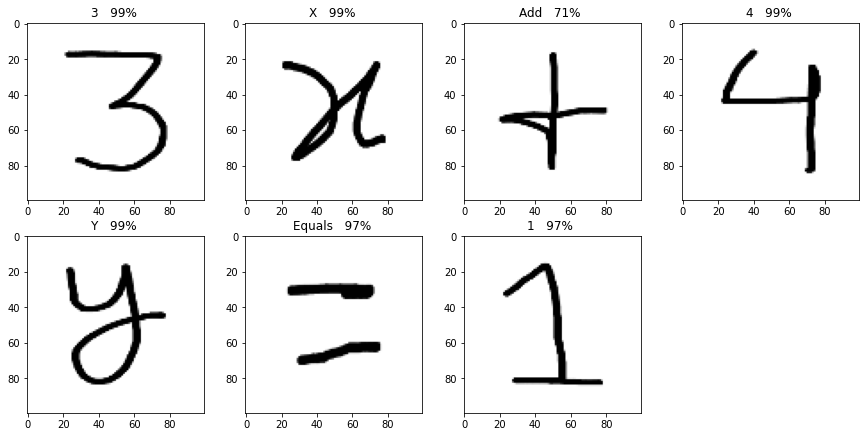

In [22]:
plt.figure(figsize=(15, 15))
for i, img in enumerate(resized_images):
    label, conf = show_prediction_lite(img)
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    title = label+'   '+ conf + '% ' 
    plt.title(title)
   
   